<a href="https://colab.research.google.com/github/JSJeong-me/CNN-Cats-Dogs/blob/main/5_aug_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline

In [5]:
!ls -l

total 110388
drwx------ 5 root root      4096 Jan 25 01:29 drive
drwxr-xr-x 1 root root      4096 Jan 20 17:27 sample_data
-rw------- 1 root root 113023590 Jan 25 01:29 training_data.zip


In [4]:
!cp ./drive/MyDrive/training_data.zip .

In [ ]:
!unzip training_data.zip


In [7]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [8]:
IMG_DIM = (150, 150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)


In [9]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

In [10]:
batch_size = 50
num_classes = 2
epochs = 100
input_shape = (150, 150, 3)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
# encode wine type labels
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[0:5], train_labels_enc[0:5])

['cat', 'cat', 'cat', 'dog', 'cat'] [0 0 0 1 0]


In [11]:
train_datagen = ImageDataGenerator( zoom_range=0.3, rotation_range=50,  # rescale=1./255,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator() # rescale=1./255

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [12]:

from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
import tensorflow.keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet',
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = tensorflow.keras.layers.Flatten()(output)

vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False

vgg_model.summary()


58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [ ]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
print("Trainable layers:", vgg_model.trainable_weights)

In [14]:
import pandas as pd
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f7b4e3ab5f8>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7b4e376be0>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7b4db2d1d0>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f7b400ead68>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7b400f5e80>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7b400fa2b0>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f7b40102390>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7b401082b0>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7b40108fd0>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7b4010f160>,block3_conv3,False


In [16]:
print("Trainable layers:", vgg_model.trainable_weights)

Trainable layers: [<tf.Variable 'block4_conv1/kernel:0' shape=(3, 3, 256, 512) dtype=float32, numpy=
array([[[[-1.24538150e-02,  8.40655994e-03, -5.28845051e-03, ...,
          -2.04581907e-03, -3.92359449e-03,  1.30683812e-03],
         [ 1.15566896e-02,  2.46055960e-03, -4.09082584e-02, ...,
          -4.92062652e-03, -1.63423386e-03,  8.94230697e-03],
         [-1.43469922e-04, -5.65873180e-03,  1.84066985e-02, ...,
          -2.08840682e-03,  2.63321817e-06, -2.50728261e-02],
         ...,
         [ 1.37888230e-02, -6.58180192e-03,  9.65370331e-03, ...,
           7.17610447e-03,  3.45725450e-03,  5.33173978e-03],
         [ 2.65833316e-03,  7.77704641e-04,  2.86239345e-04, ...,
          -5.40583069e-03,  8.93119723e-03,  1.40043022e-02],
         [-8.53933115e-03,  1.43394794e-03, -2.91879033e-03, ...,
           3.77660524e-03,  2.05454584e-02, -1.35868033e-02]],

        [[-1.20176468e-02,  1.51250837e-03,  3.43130133e-03, ...,
          -1.57830697e-02, -2.39501009e-03,  2.93

(1, 4, 4, 512)


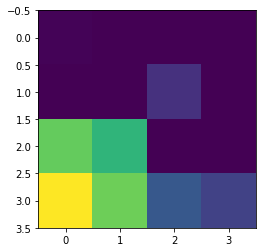

In [15]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [17]:
def get_bottleneck_features(model, input_imgs):
    
    features = model.predict(input_imgs, verbose=0)
    return features

In [18]:
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (3000, 8192) 	Validation Bottleneck Features: (1000, 8192)


In [19]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 8192)              14714688  
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 18,942,401
Trainable params: 17,206,913
Non-trainable params: 1,735,488
____________________________________

In [20]:
history = model.fit_generator(train_generator,  epochs=epochs,
                              validation_data=val_generator,  verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 [==============================] - 23s 209ms/step - loss: 2.2883 - accuracy: 0.5586 - val_loss: 0.3799 - val_accuracy: 0.8300
Epoch 2/100
100/100 [==============================] - 20s 202ms/step - loss: 0.5314 - accuracy: 0.7272 - val_loss: 0.2606 - val_accuracy: 0.9160
Epoch 3/100
100/100 [==============================] - 20s 201ms/step - loss: 0.3693 - accuracy: 0.8221 - val_loss: 0.3955 - val_accuracy: 0.9150
Epoch 4/100
100/100 [==============================] - 20s 202ms/step - loss: 0.3112 - accuracy: 0.8721 - val_loss: 0.2112 - val_accuracy: 0.9370
Epoch 5/100
100/100 [==============================] - 20s 201ms/step - loss: 0.2497 - accuracy: 0.8938 - val_loss: 0.1980 - val_accuracy: 0.9380
Epoch 6/100
100/100 [==============================] - 20s 203ms/step - loss: 0.2185 - accuracy: 0.9091 - val_loss: 0.1854 - val_accuracy: 0.9460
Epoch 7/100
100/100 [==============================] - 20s 204ms/step - loss: 0.2089 - accuracy: 0.9122 - val_loss: 0.2385 -

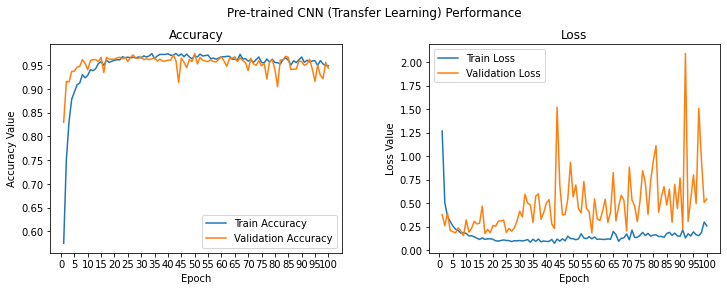

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [22]:
model.save('5-pre-aug-vgg16.h5')